In [1]:
%%time
# Imports
from utils import *

CPU times: total: 2.31 s
Wall time: 13.5 s


File-Reading

In [2]:
%%time

# Get start time
start = time.perf_counter()

# File-Reading
path = os.path.join(os.getcwd() , out_file) # from utils
user = []
ts = []
ca = []
tweets = []
# mentions = []
# coord = []
# country = []

with open(path , 'r' , encoding='utf-8') as in_file:
    csv_reader = csv.reader(in_file , delimiter = "|")
    for line in csv_reader:
        user.append(line[0])
        ts.append(line[1])
        ca.append(line[2])
        tweets.append(line[3])
        # mentions.append(line[4])
        # coord.append(line[5])
        # country.append(line[6])

CPU times: total: 27.6 s
Wall time: 28.6 s


Checking for disparity between timestamp column and created_at column

In [ ]:
%%time

ts_convert = [datetime.datetime.fromtimestamp(int(dt)//1000) for dt in ts]

# Make DF
twt_time_df = pd.DataFrame(
    list(zip(ts_convert , ca)) , 
    columns = ['ts' , 'created_at']
)

# twt_time_df['ts'] = pd.to_datetime(twt_time_df['ts'].apply(lambda x : x[:-3]) , unit = 's')

# Remove unnecessary rows - Instate a check here. Removed rows should be ~322
twt_time_df = twt_time_df[twt_time_df['created_at']!= "None"]
# Remove Time Zone Stamp
twt_time_df['created_at'] = twt_time_df['created_at'].apply(lambda x : str(x)[:19] + ' ' + str(x)[-4:])

twt_time_df['created_at'] = pd.to_datetime(twt_time_df['created_at'])
# 3 min 31 sec

twt_time_df['diff'] = (twt_time_df['ts'] - twt_time_df['created_at'])/pd.Timedelta(hours = 1)

CPU times: total: 3min 6s
Wall time: 3min 6s


In [ ]:
print(twt_time_df['diff'].nunique())
print(twt_time_df.head(2))
print(twt_time_df.tail(2))

1
          ts          created_at  diff
0 2022-06-01 2022-05-31 23:00:00   1.0
1 2022-06-01 2022-05-31 23:00:00   1.0
                          ts          created_at  diff
15040707 2022-06-30 23:59:59 2022-06-30 22:59:59   1.0
15040708 2022-06-30 23:59:59 2022-06-30 22:59:59   1.0


In [ ]:
# Clean up
del twt_time_df , ca

One can hazard a guess as to why there is this consistent time difference:<br/>
Between March and October of a given year, UK Time or British Standard Time is 1 hour ahead of UTC. <br/>
Therefore, there seems to be a 1 hour lag in the UTC timestamps, as the tweets were scraped between Jun 1st and Jun 30th **UK time** 

# **01 - BASIC STATS**
### **Question - 1**

In [3]:
%%time
# Remove None tweets - there are a few
tweets_non_null = [tweet for tweet in tweets if tweet!="None"]
tweets_null = [tweet for tweet in tweets if tweet=="None"]

# Duplicate Identification
tweets_non_null_2 = np.sort(np.array(tweets_non_null))
# duplicates contains ONLY the duplicates (for each: however many times they repeated minus 1)
duplicates = tweets_non_null_2[:-1][tweets_non_null_2[1:]==tweets_non_null_2[:-1]] # https://stackoverflow.com/questions/11528078/determining-duplicate-values-in-an-array

# Question - 1
print(f'The total number of tweets is {len(set(tweets_non_null))} with {len(set(duplicates))} occupying {len(duplicates)} places. {len(tweets_null)} records do not have tweet ID')

The total number of tweets is 15033548 with 5666 occupying 6839 places. 322 records do not have tweet ID
CPU times: total: 8.45 s
Wall time: 8.46 s


### **Question - 2**

CPU times: total: 1min 32s
Wall time: 1min 32s


Text(0, 0.5, 'No. of Tweets')

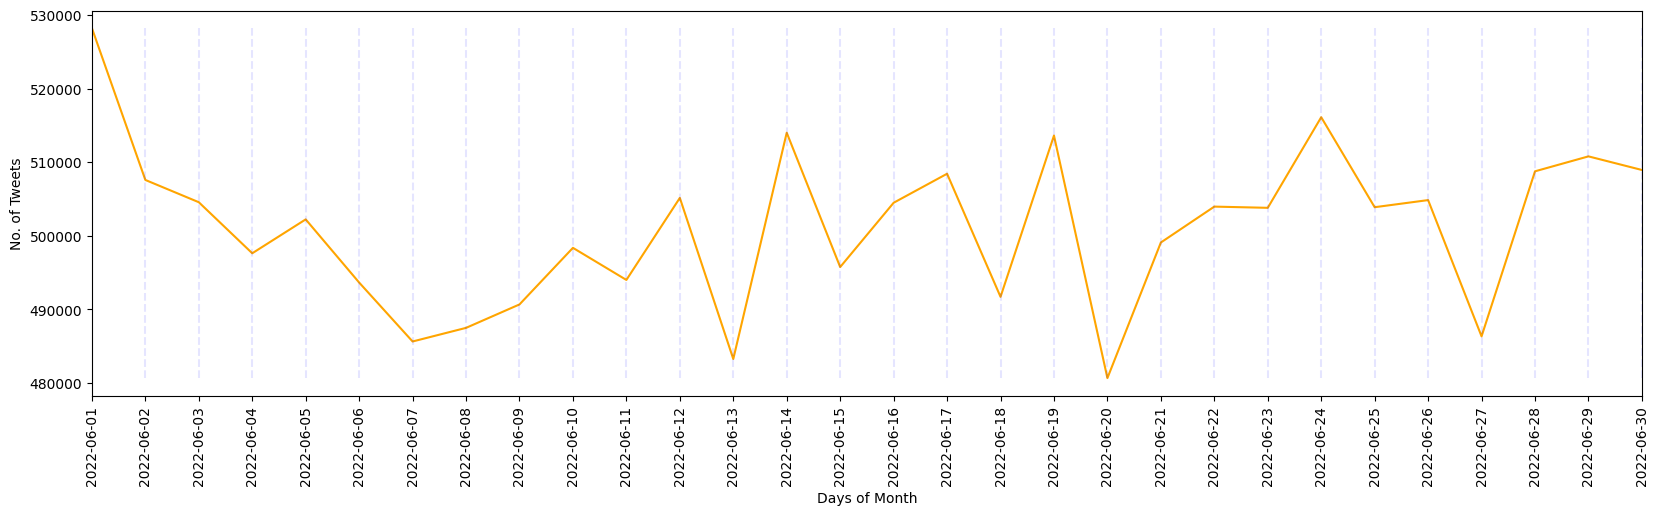

In [5]:
%%time
ts_convert = [datetime.datetime.fromtimestamp(int(dt)/1000) for dt in ts]

twt_df = pd.DataFrame(list(zip(user , ts_convert , tweets)) , columns = ['user' , 'ts' , 'tweet_id'])
twt_df = twt_df[twt_df['tweet_id']!="None"].drop_duplicates()

# QC
assert len(twt_df) == len(set(tweets_non_null)) , "length of db does not match"

# Correctness Check - one tweet cannot have more than 1 author or less than 1 author
assert twt_df.groupby('tweet_id').agg(num_auth = ('user','nunique')).reset_index().sort_values('num_auth' , ascending = False).iloc[0]['num_auth'] == 1 , 'tweet cannot have moree than one author'

# Create a date column
twt_df['ts_day'] = pd.to_datetime(twt_df['ts']).dt.date # https://www.geeksforgeeks.org/how-to-convert-datetime-to-date-in-pandas/

# Group at day level
twt_daily = twt_df.groupby('ts_day').agg(num_tweets = ('tweet_id','nunique'))

# Plot
fig , ax = plt.subplots(figsize = (20 , 5))
ax.plot(twt_daily['num_tweets'] , color = 'orange');
ax.vlines(
    twt_daily.index , 
    ymin = min(twt_daily['num_tweets']) , 
    ymax = max(twt_daily['num_tweets']) ,
    color = 'blue' ,
    alpha = 0.1 ,
    ls = '--'
);
ax.set_xticks(twt_daily.index);
ax.set_xticklabels(labels = twt_daily.index, rotation = 90);

plt.xlim(min(twt_daily.index) , max(twt_daily.index));
# plt.xticks(rotation = 90);
# plt.xticks(twt_daily.index);
plt.xlabel('Days of Month');
plt.ylabel('No. of Tweets');

**Comments**:<br/>
Tweets seem to be falling slightly on Mondays/ Tuesdays, which sort of makes sense as people resume work after the weekend.

### **Question - 3**

In [6]:
%%time
# Create a weekday-or-not column
twt_df['weekday'] = np.where(pd.to_datetime(twt_df['ts']).dt.day_of_week <= 4 , 1 , 0)

# Should be close to 22/8 = 2.75 if there's no real difference in the amount of tweets between weekends and weekdays
print(np.round(len(twt_df[twt_df['weekday'] == 1])/len(twt_df[twt_df['weekday'] == 0]) , 2))

2.75
CPU times: total: 4.12 s
Wall time: 4.22 s


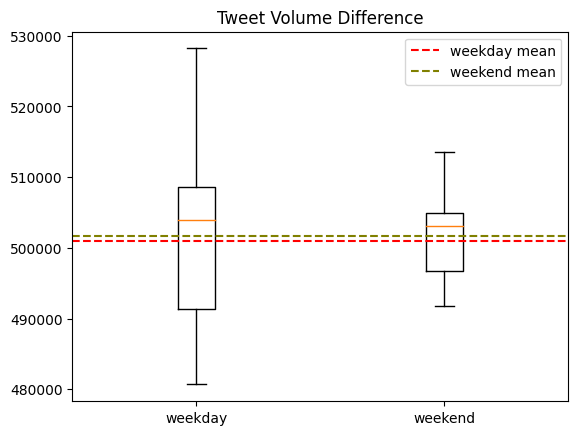

In [10]:
# Preparing Boxplot
twt_df_grp = twt_df.groupby(['ts_day' , 'weekday']).agg(num_tweets = ('tweet_id' , 'nunique')).reset_index()
twt_df_grp_wkday = twt_df_grp[twt_df_grp['weekday']==1]
t1 = twt_df_grp_wkday['num_tweets'].tolist()

twt_df_grp_wkend = twt_df_grp[twt_df_grp['weekday']==0]
t2 = twt_df_grp_wkend['num_tweets'].tolist()

week_tweet_dict = {
    'weekday':t1 , 
    'weekend':t2
    }

# Plot
fig , ax = plt.subplots()
ax.boxplot(week_tweet_dict.values() , whis = None);
ax.set_xticklabels(week_tweet_dict.keys());
ax.axhline(np.mean(t1) , ls = '--' , c = 'red' , label = 'weekday mean');
ax.axhline(np.mean(t2) , ls = '--' , c = 'olive' , label = 'weekend mean');
plt.legend(loc = 'best');
plt.title('Tweet Volume Difference');

Correlation coefficient is 0.6261623577774496


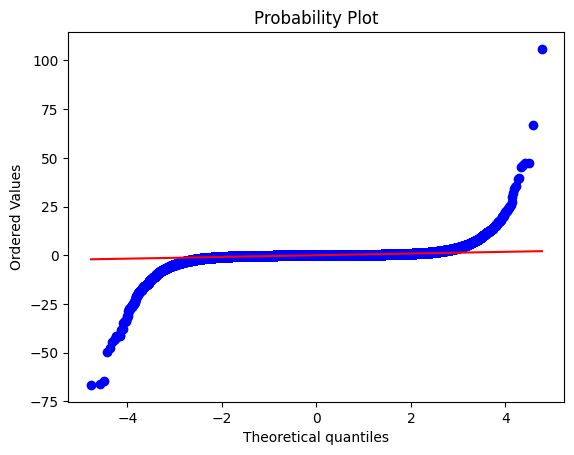

In [11]:
# More Rigourous Testing is necessary
hypo_test_df = twt_df.pivot_table(
    index = ['user'] , 
    columns = ['weekday'] , 
    values = ['tweet_id' , 'ts_day'] , 
    aggfunc = 'nunique'
    ).reset_index().fillna(0)

# Reset the  column names
hypo_test_df.columns = ['user' , 'weekends' , 'weekdays' , 'weekend_tweets' , 'weekday_tweets']

# Collect average weekend and weekday tweets at user level
hypo_test_df['avg_weekend_tweets'] = hypo_test_df['weekend_tweets']/hypo_test_df['weekends']
hypo_test_df['avg_weekday_tweets'] = hypo_test_df['weekday_tweets']/hypo_test_df['weekdays']

hypo_test_df.fillna(0 , inplace = True)

# Standardize
hypo_test_df['avg_weekend_tweets'] = (hypo_test_df['avg_weekend_tweets'] - np.mean(hypo_test_df['avg_weekend_tweets']))/np.std(hypo_test_df['avg_weekend_tweets'])
hypo_test_df['avg_weekday_tweets'] = (hypo_test_df['avg_weekday_tweets'] - np.mean(hypo_test_df['avg_weekday_tweets']))/np.std(hypo_test_df['avg_weekday_tweets'])

# We will test if this difference is normal(-ish); that will allow us to conduct t-tests on the data 
hypo_test_df['mean_diff'] = hypo_test_df['avg_weekend_tweets'] - hypo_test_df['avg_weekday_tweets']

(osm, osr), (slope, intercept, r) = scipy.stats.probplot(hypo_test_df['mean_diff'] , plot = plt);
print(f'Correlation coefficient is {r}')

In [24]:
np.var(hypo_test_df['avg_weekend_tweets']) , np.var(hypo_test_df['avg_weekday_tweets'])

(0.9999999999999999, 1.0000000000000002)

In [27]:
len(hypo_test_df['avg_weekday_tweets'])

753481

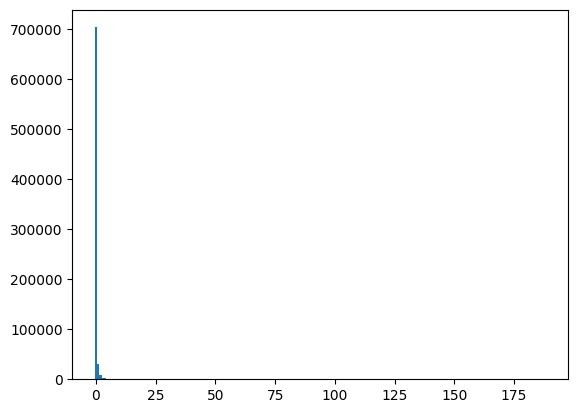

In [25]:
plt.hist(hypo_test_df['avg_weekday_tweets'] , bins = 200);

This doesn't look to be very normal. However, let us remind ourselves that with large N, t-test is not _that_ sensitive to non-normal data <br/>
Because of such large data, CLT will help in us being able to use a t-test! <br/>
**Reference**: https://thestatsgeek.com/2013/09/28/the-t-test-and-robustness-to-non-normality/


CPU times: total: 7.05 s
Wall time: 6.92 s


Text(0, 0.5, 'Occurrences')

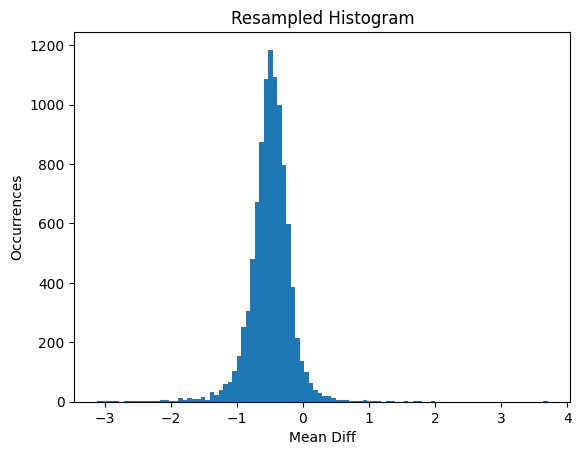

In [55]:
%%time
# Simulate CLT
X = np.array(hypo_test_df['mean_diff'])
sample_size = 100
N = 10000
collect = []
for _ in range(N):
    sample = [np.random.choice(X) for i in range(100)]
    sample_mean = np.mean(sample)
    collect.append(sample_mean)

fig , ax = plt.subplots()
freq , bins , patches = ax.hist(collect , bins = 100);
plt.title('Resampled Histogram');
ax.set_xlabel('Mean Diff');
ax.set_ylabel('Occurrences');

# Lo and behold, it is normal - we can use a paired ttest (scipy.stats.ttest_rel)

In [10]:
%%time
# Standardize the data
avg_weekday_twt = (np.array(hypo_test_df['avg_weekday_tweets']) - np.mean(np.array(hypo_test_df['avg_weekday_tweets'])))/np.std(np.array(hypo_test_df['avg_weekday_tweets']))
avg_weekdend_twt = (np.array(hypo_test_df['avg_weekend_tweets']) - np.mean(np.array(hypo_test_df['avg_weekend_tweets'])))/np.std(np.array(hypo_test_df['avg_weekend_tweets']))

# Set up the Hypothesis test
# H0: There is no difference between the means
# Paired T Test - see if u want to implement a two sided t test or a one sample t test? 
scipy.stats.ttest_rel(avg_weekday_twt , avg_weekdend_twt, alternative = 'two-sided')

CPU times: total: 15.6 ms
Wall time: 34.9 ms


Ttest_relResult(statistic=2.654590994409255e-14, pvalue=0.9999999999999788)

**Such a high p-value says:**
1. There is definitely not enough evidence to reject the Null Hypothesis that the two means are equal.
2. The two datasets are most likely highly correlated; a correlation test would likely yield a very high coefficient

In [11]:
%%time
scipy.stats.pearsonr(avg_weekday_twt , avg_weekdend_twt)

CPU times: total: 15.6 ms
Wall time: 18.8 ms


PearsonRResult(statistic=0.7548022023741843, pvalue=0.0)

CPU times: total: 31.2 ms
Wall time: 32.8 ms


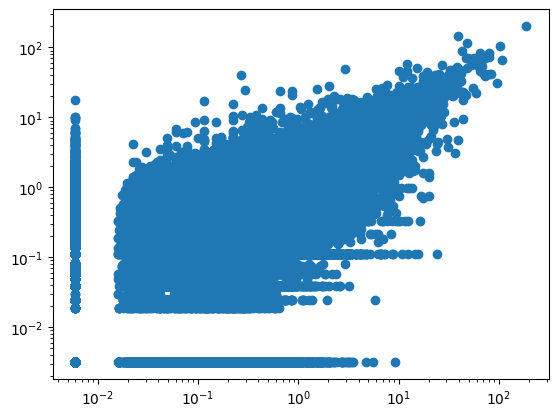

In [12]:
%%time
plt.scatter(avg_weekday_twt , avg_weekdend_twt);
plt.xscale('log');
plt.yscale('log');

**They appear to be roughly correlated, albeit not to a great degree (75%)**

### **Question - 4**

In [13]:
%%time
day_df = pd.DataFrame(
    [
        [0 , 'Mon'],
        [1 , 'Tue'],
        [2 , 'Wed'],
        [3 , 'Thu'],
        [4 , 'Fri'],
        [5 , 'Sat'],
        [6 , 'Sun'],
    ] ,
    columns = ['day' , 'dayofweek']
)

CPU times: total: 0 ns
Wall time: 0 ns


In [14]:
%%time
twt_df['hour'] = twt_df['ts'].dt.hour
twt_df['day'] = twt_df['ts'].dt.day_of_week
twt_df = twt_df.merge(day_df , on = 'day' , how = 'inner')

CPU times: total: 4.2 s
Wall time: 4.47 s


In [15]:
%%time
twt_df_hr = twt_df.groupby(['hour' , 'dayofweek']).agg(num_tweets = ('tweet_id','nunique')).reset_index()

CPU times: total: 13.2 s
Wall time: 13.7 s


In [16]:
%%time
# Check
twt_df_hr.sum().num_tweets

CPU times: total: 0 ns
Wall time: 6.82 ms


15033548

In [17]:
%%time
twt_df_hr_only = twt_df_hr.groupby('hour').agg(num_tweets_avg = ('num_tweets' , np.mean))

CPU times: total: 0 ns
Wall time: 6.26 ms


CPU times: total: 62.5 ms
Wall time: 41.4 ms


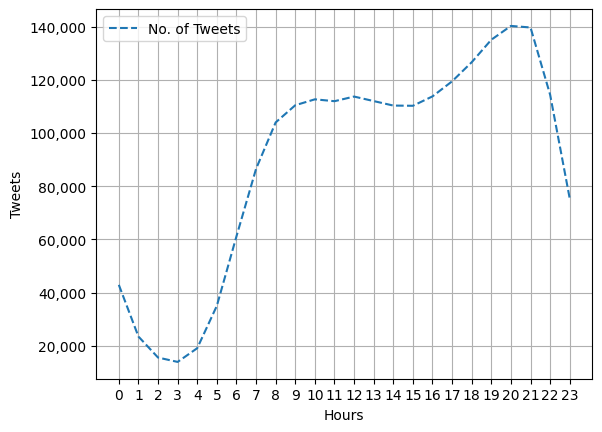

In [18]:
%%time
fig , ax = plt.subplots()

ax.plot(twt_df_hr_only , ls = '--' , label = 'No. of Tweets');
plt.xticks(twt_df_hr_only.index);
ax.grid();
ax.legend(loc = 'best');
ax.set_xlabel('Hours');
ax.set_ylabel('Tweets');
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#https://stackoverflow.com/questions/51734218/formatting-y-axis-matplotlib-with-thousands-separator-and-font-size

**Comment on Pattern** <br/>
Starting from 12 midnight, we see a decline in the number of tweets as more and more people go to bed. This number starts picking up after 2 AM - 3AM as people start getting up (remember there are a couple of timezones captured in this data). The number climbs sharply till about 8 AM, which is likely when most users clock in to their daily work/ school, (or start commuting to work/ school etc). Tweets stay plateaued at this range till around 3 PM, from where it starts hiking upwards again - people are liekly leaving work/ school at this time. Number continues to increase until roughly 10 PM at night, which is when we see a sharp decline, likely due to users retiring for the day/ going to bed. <br/>
As a bonus, let's look at the pattern over the days separately instead of averaging them

In [19]:
%%time
twt_df_2 = twt_df.copy()
twt_df_2['day_hr'] = twt_df_2['day']*100+twt_df_2['hour']
twt_df_3 = twt_df_2.groupby('day_hr').agg(num_tweets = ('tweet_id' , 'nunique')).reset_index()
twt_df_3['day_hr'] = twt_df_3['day_hr'].astype('str').str.zfill(4)

CPU times: total: 14.2 s
Wall time: 15.1 s


CPU times: total: 141 ms
Wall time: 156 ms


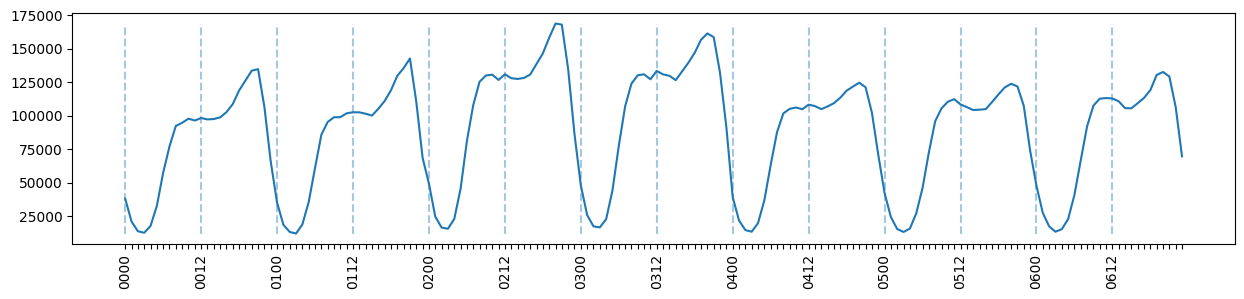

In [20]:
%%time
fig , ax = plt.subplots(figsize = (15 , 3))
ax.plot(twt_df_3.day_hr , twt_df_3.num_tweets);
#ax.grid();

plt.xticks(rotation = 90);

every_nth = 12
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

ax.vlines(
    twt_df_3.day_hr[::12] , 
    ymin = twt_df_3.num_tweets.min() , 
    ymax = twt_df_3.num_tweets.max() ,
    alpha = 0.4 , ls = '--');

**It seems like although the hourly pattern is mostly preserved in the number of tweets, Wednesdays and Thursdays see on average the highest volume of tweets** 